In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import gc
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb


In [2]:
pd.set_option('display.max_columns', 100)

In [4]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018


MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os

if(IS_LOCAL):
    PATH="./input/credit-card-fraud-detection"
else:
    PATH="./input"

print(os.listdir(PATH))

['creditcard.csv']


In [5]:
data_df = pd.read_csv(PATH+"/creditcard.csv")
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 284807  columns: 31


In [6]:
data_df.head()
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Time,V16,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V19,V18,V17,V15,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,Class
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True), 
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600,paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
         )
fig = dict(data=data, layout=layout)

iplot(fig, filename='class')

fig.savefig('fraud-graphs/class.png',transparent=True)

# save the plot

AttributeError: 'dict' object has no attribute 'savefig'

In [44]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'),paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)')
iplot(fig, filename='dist_only')

In [59]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


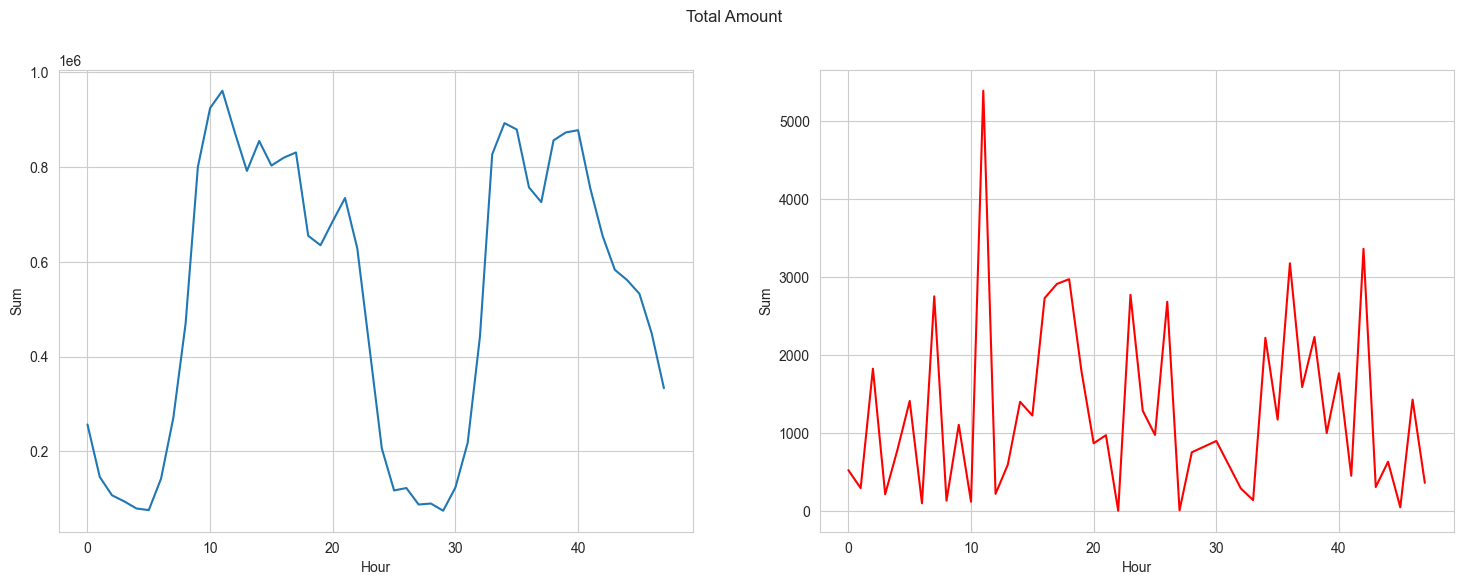

In [60]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
fig.savefig('fraud-graphs/transparent_figure.png', transparent=True)

plt.show()

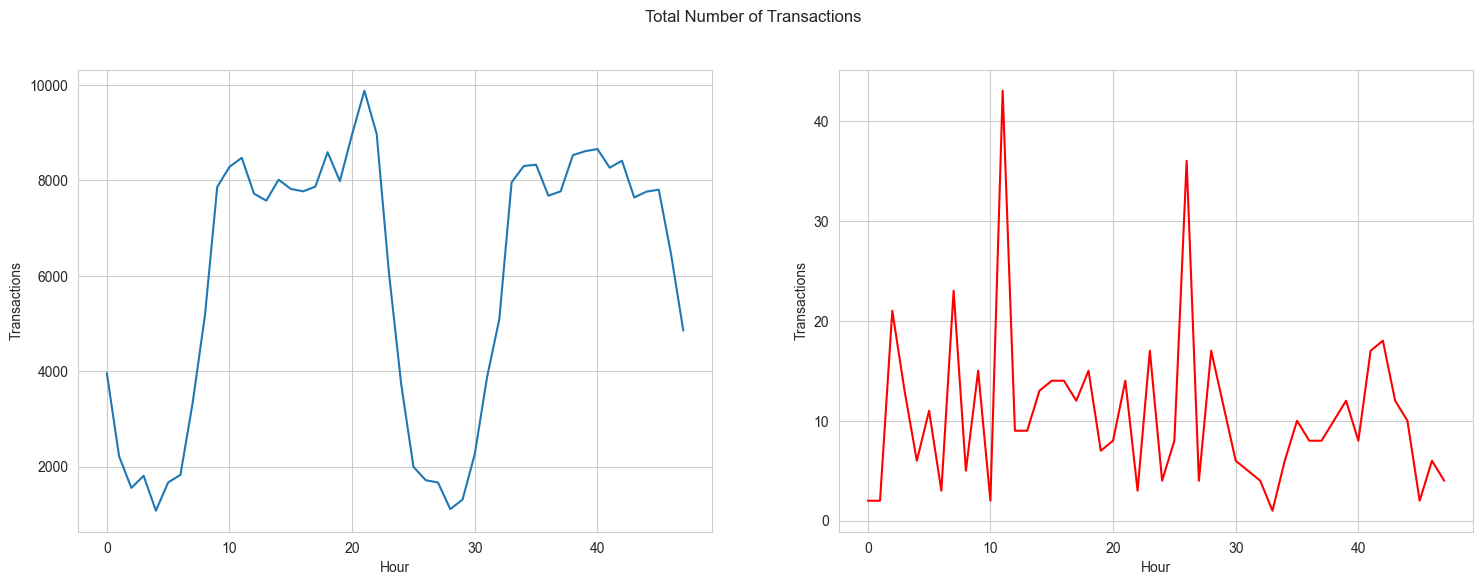

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
fig.savefig('fraud-graphs/total_transactions.png', transparent=True)

plt.show()

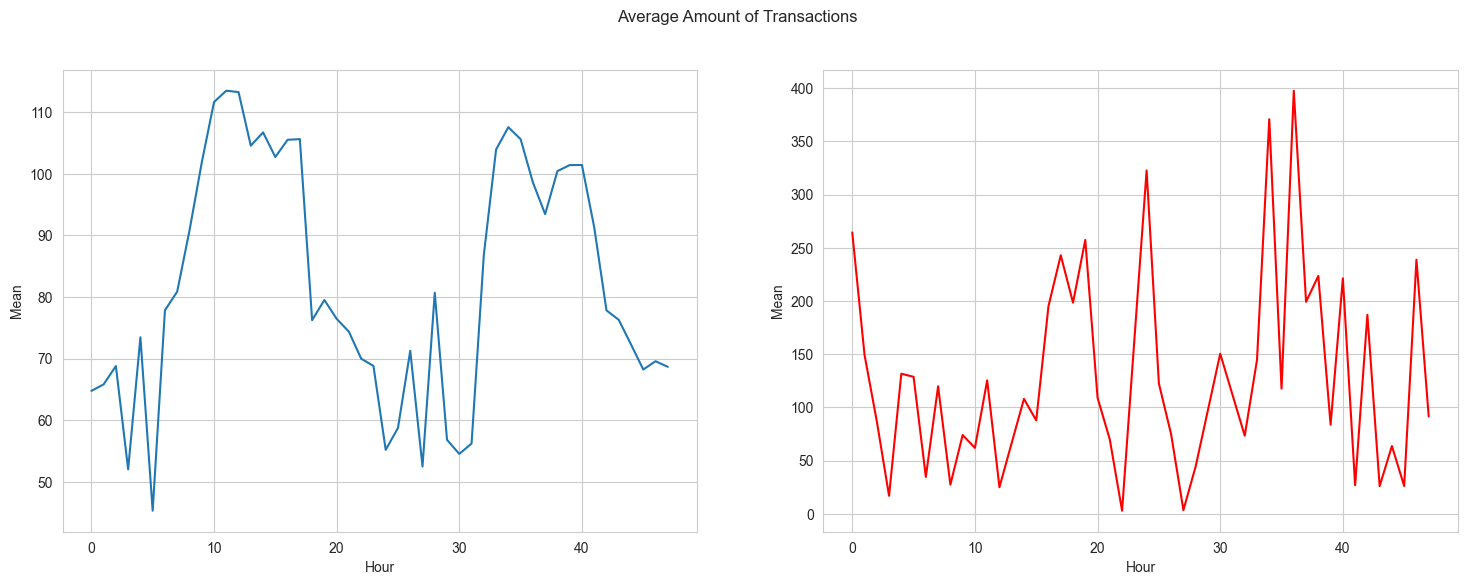

In [62]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
fig.savefig('fraud-graphs/average_amount.png', transparent=True)
plt.show()

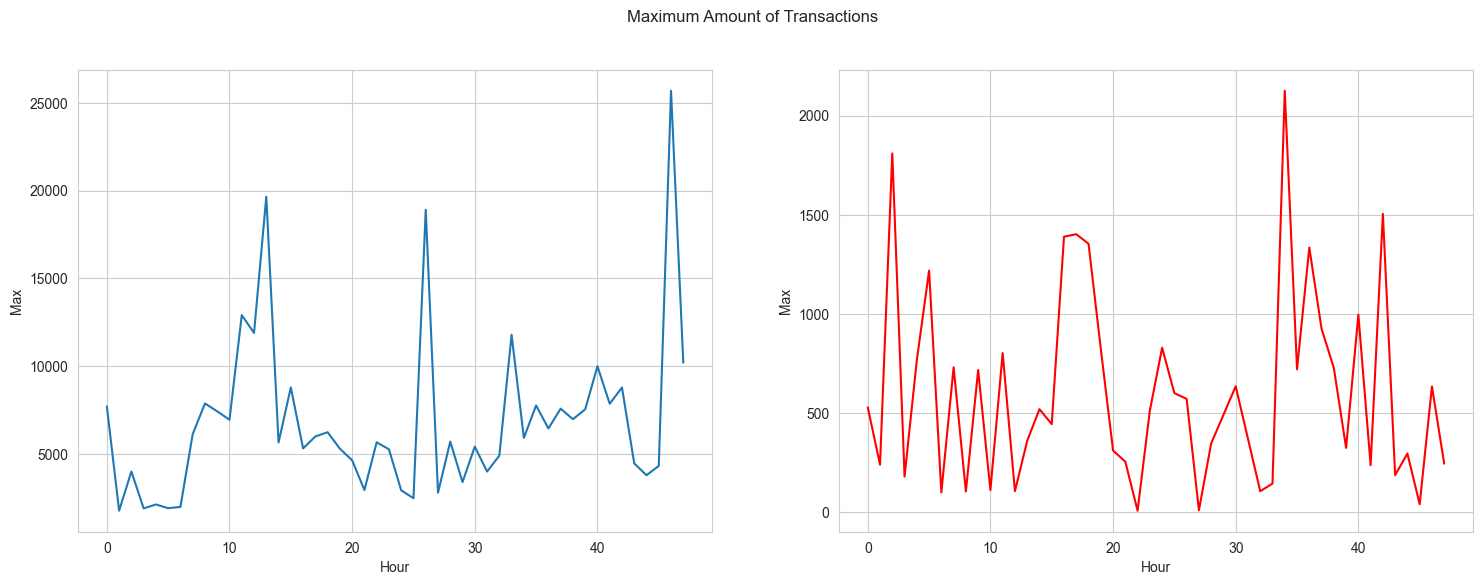

In [63]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
fig.savefig('fraud-graphs/max_amount.png', transparent=True)
plt.show()

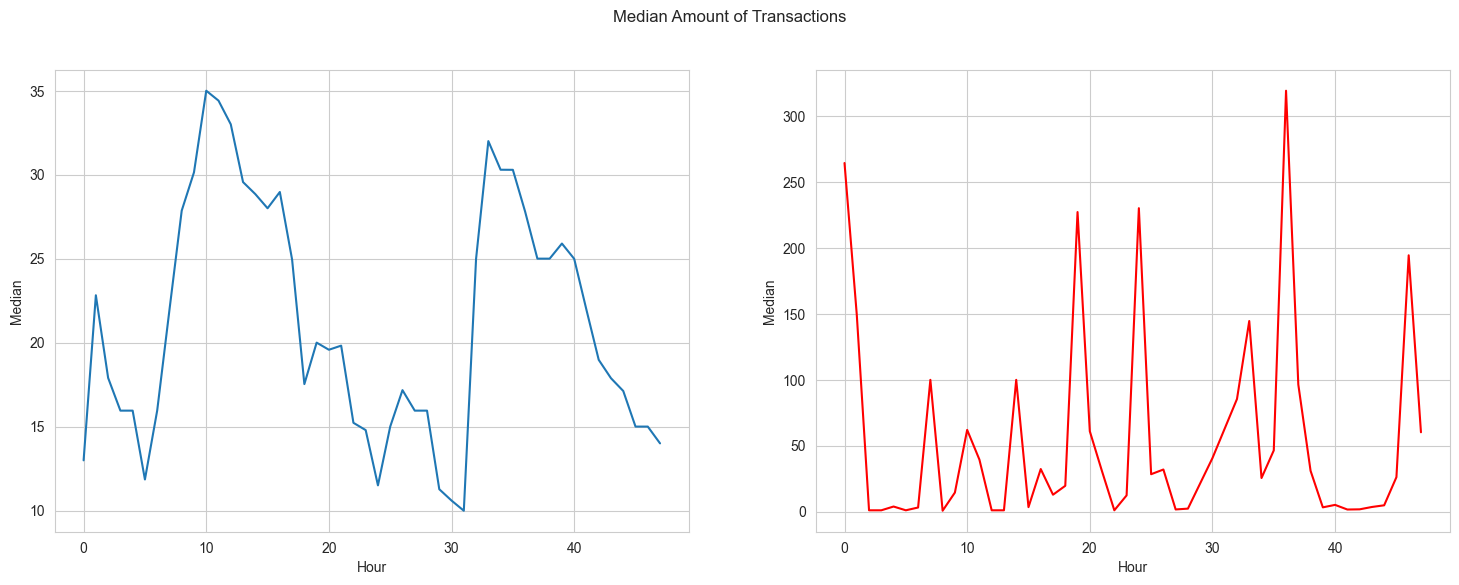

In [64]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
fig.savefig('fraud-graphs/median_amount.png', transparent=True)
plt.show()

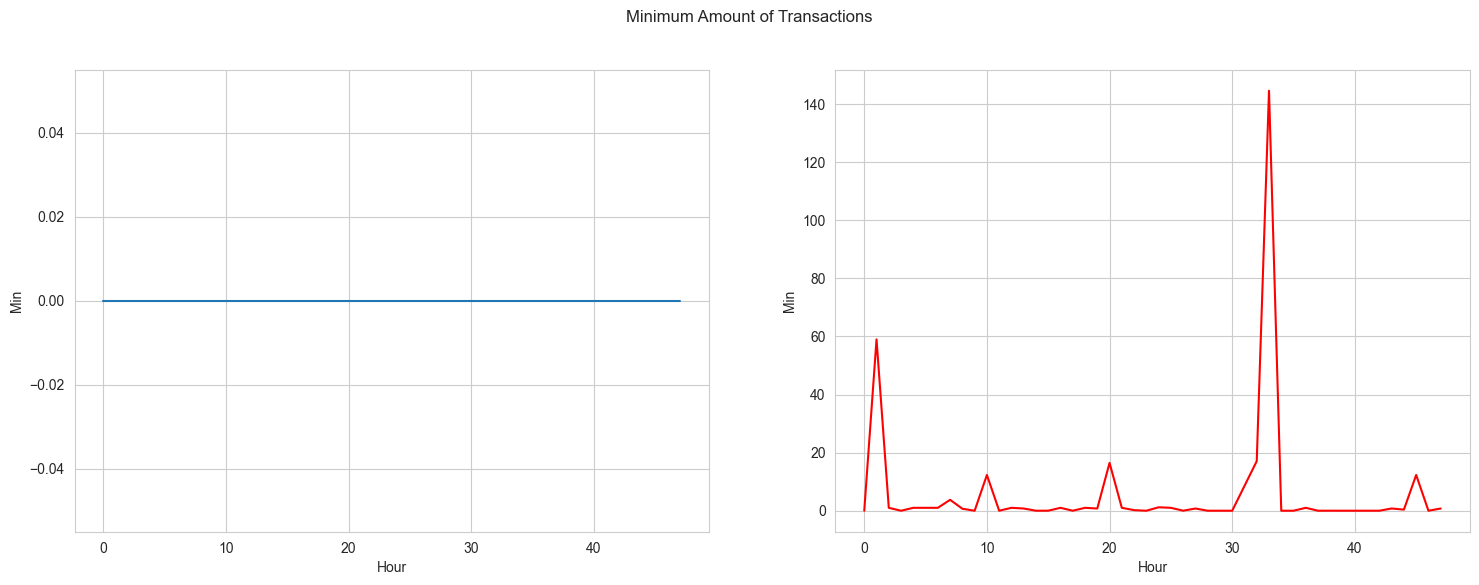

In [65]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
fig.savefig('fraud-graphs/min_amount.png', transparent=True)
plt.show()

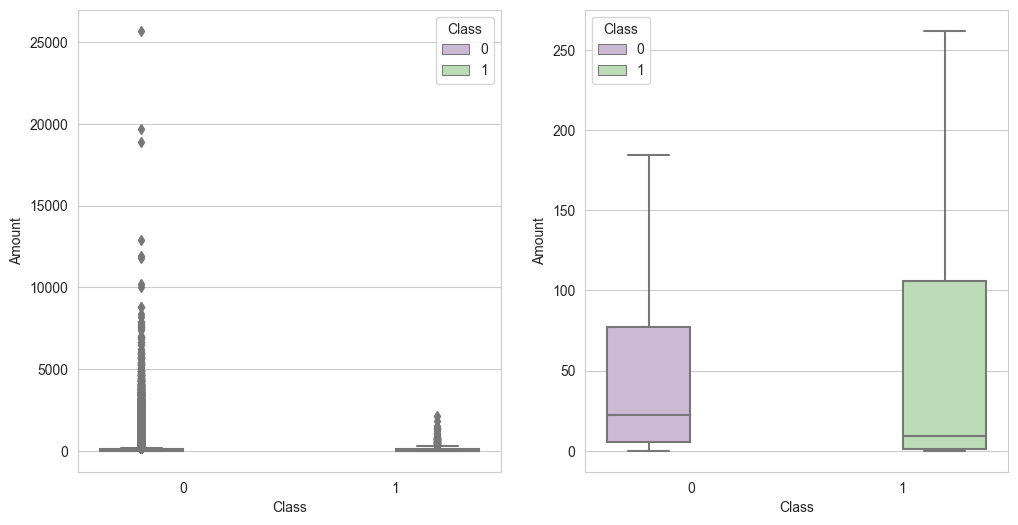

In [66]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
fig.savefig('fraud-graphs/boxplot.png', transparent=True)
plt.show()

In [67]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [20]:
class_1.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [73]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True), 
          yaxis = dict(title = 'Amount'),
          hovermode='closest',paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')



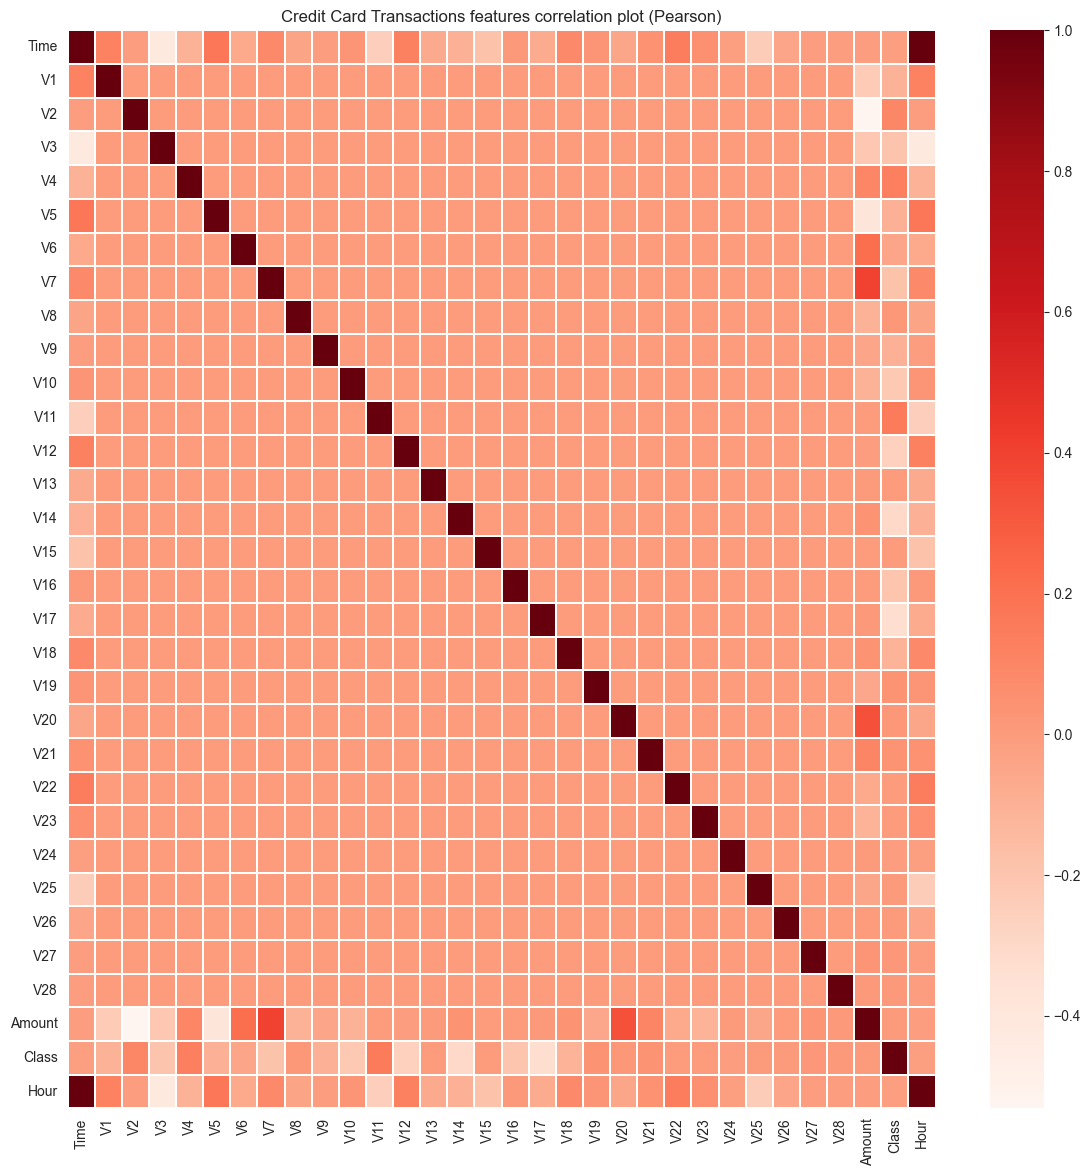

<Figure size 640x480 with 0 Axes>

In [79]:
plt.figure(figsize = (14,14), )
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")

plt.show()
plt.savefig('fraud-graphs/correlation.png', transparent=True, bbox_inches='tight')

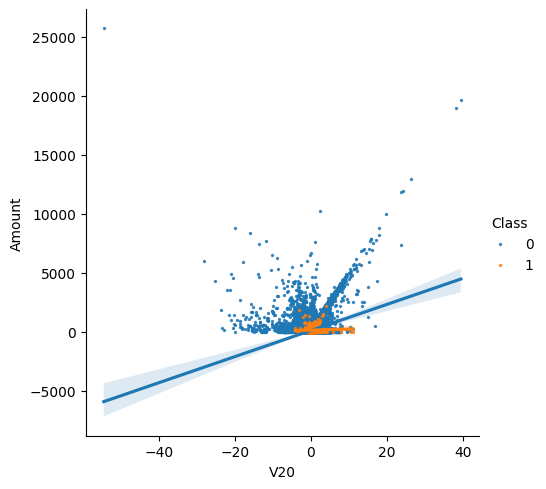

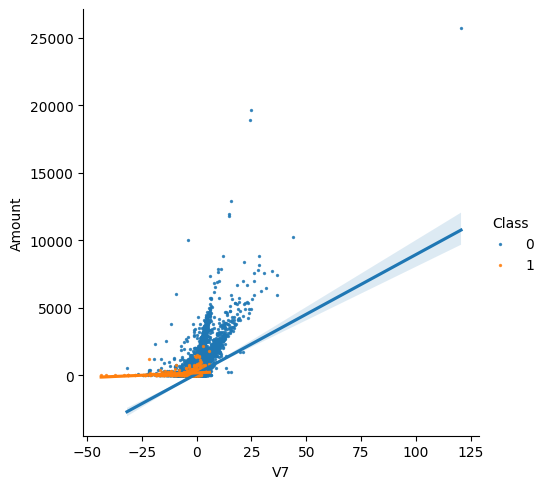

In [23]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

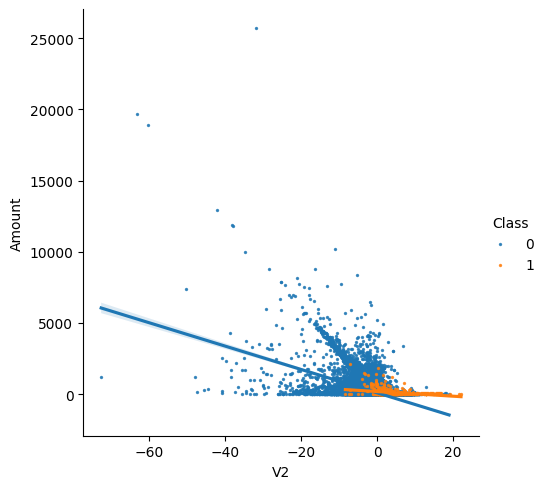

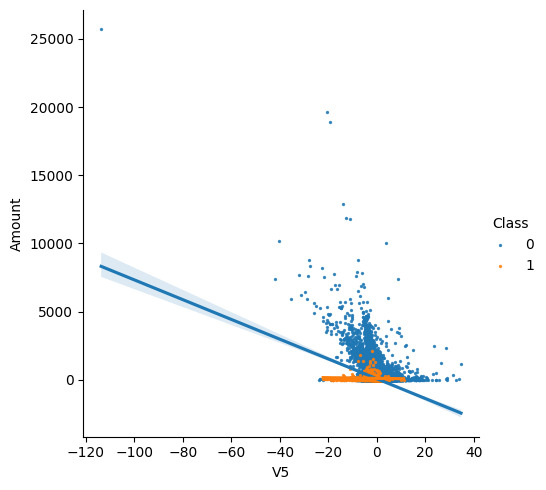

In [24]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

/var/folders/tq/51lzs6fs387bwv1r_7v0yn9w0000gn/T/ipykernel_41134/2769832653.py:17: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


/var/folders/tq/51lzs6fs387bwv1r_7v0yn9w0000gn/T/ipykernel_41134/2769832653.py:18: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


/var/folders/tq/51lzs6fs387bwv1r_7v0yn9w0000gn/T/ipykernel_41134/2769832653.py:17: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


/var/folders/tq/51lzs6fs387bwv1r_7v0yn9w0000gn/T/ipyker

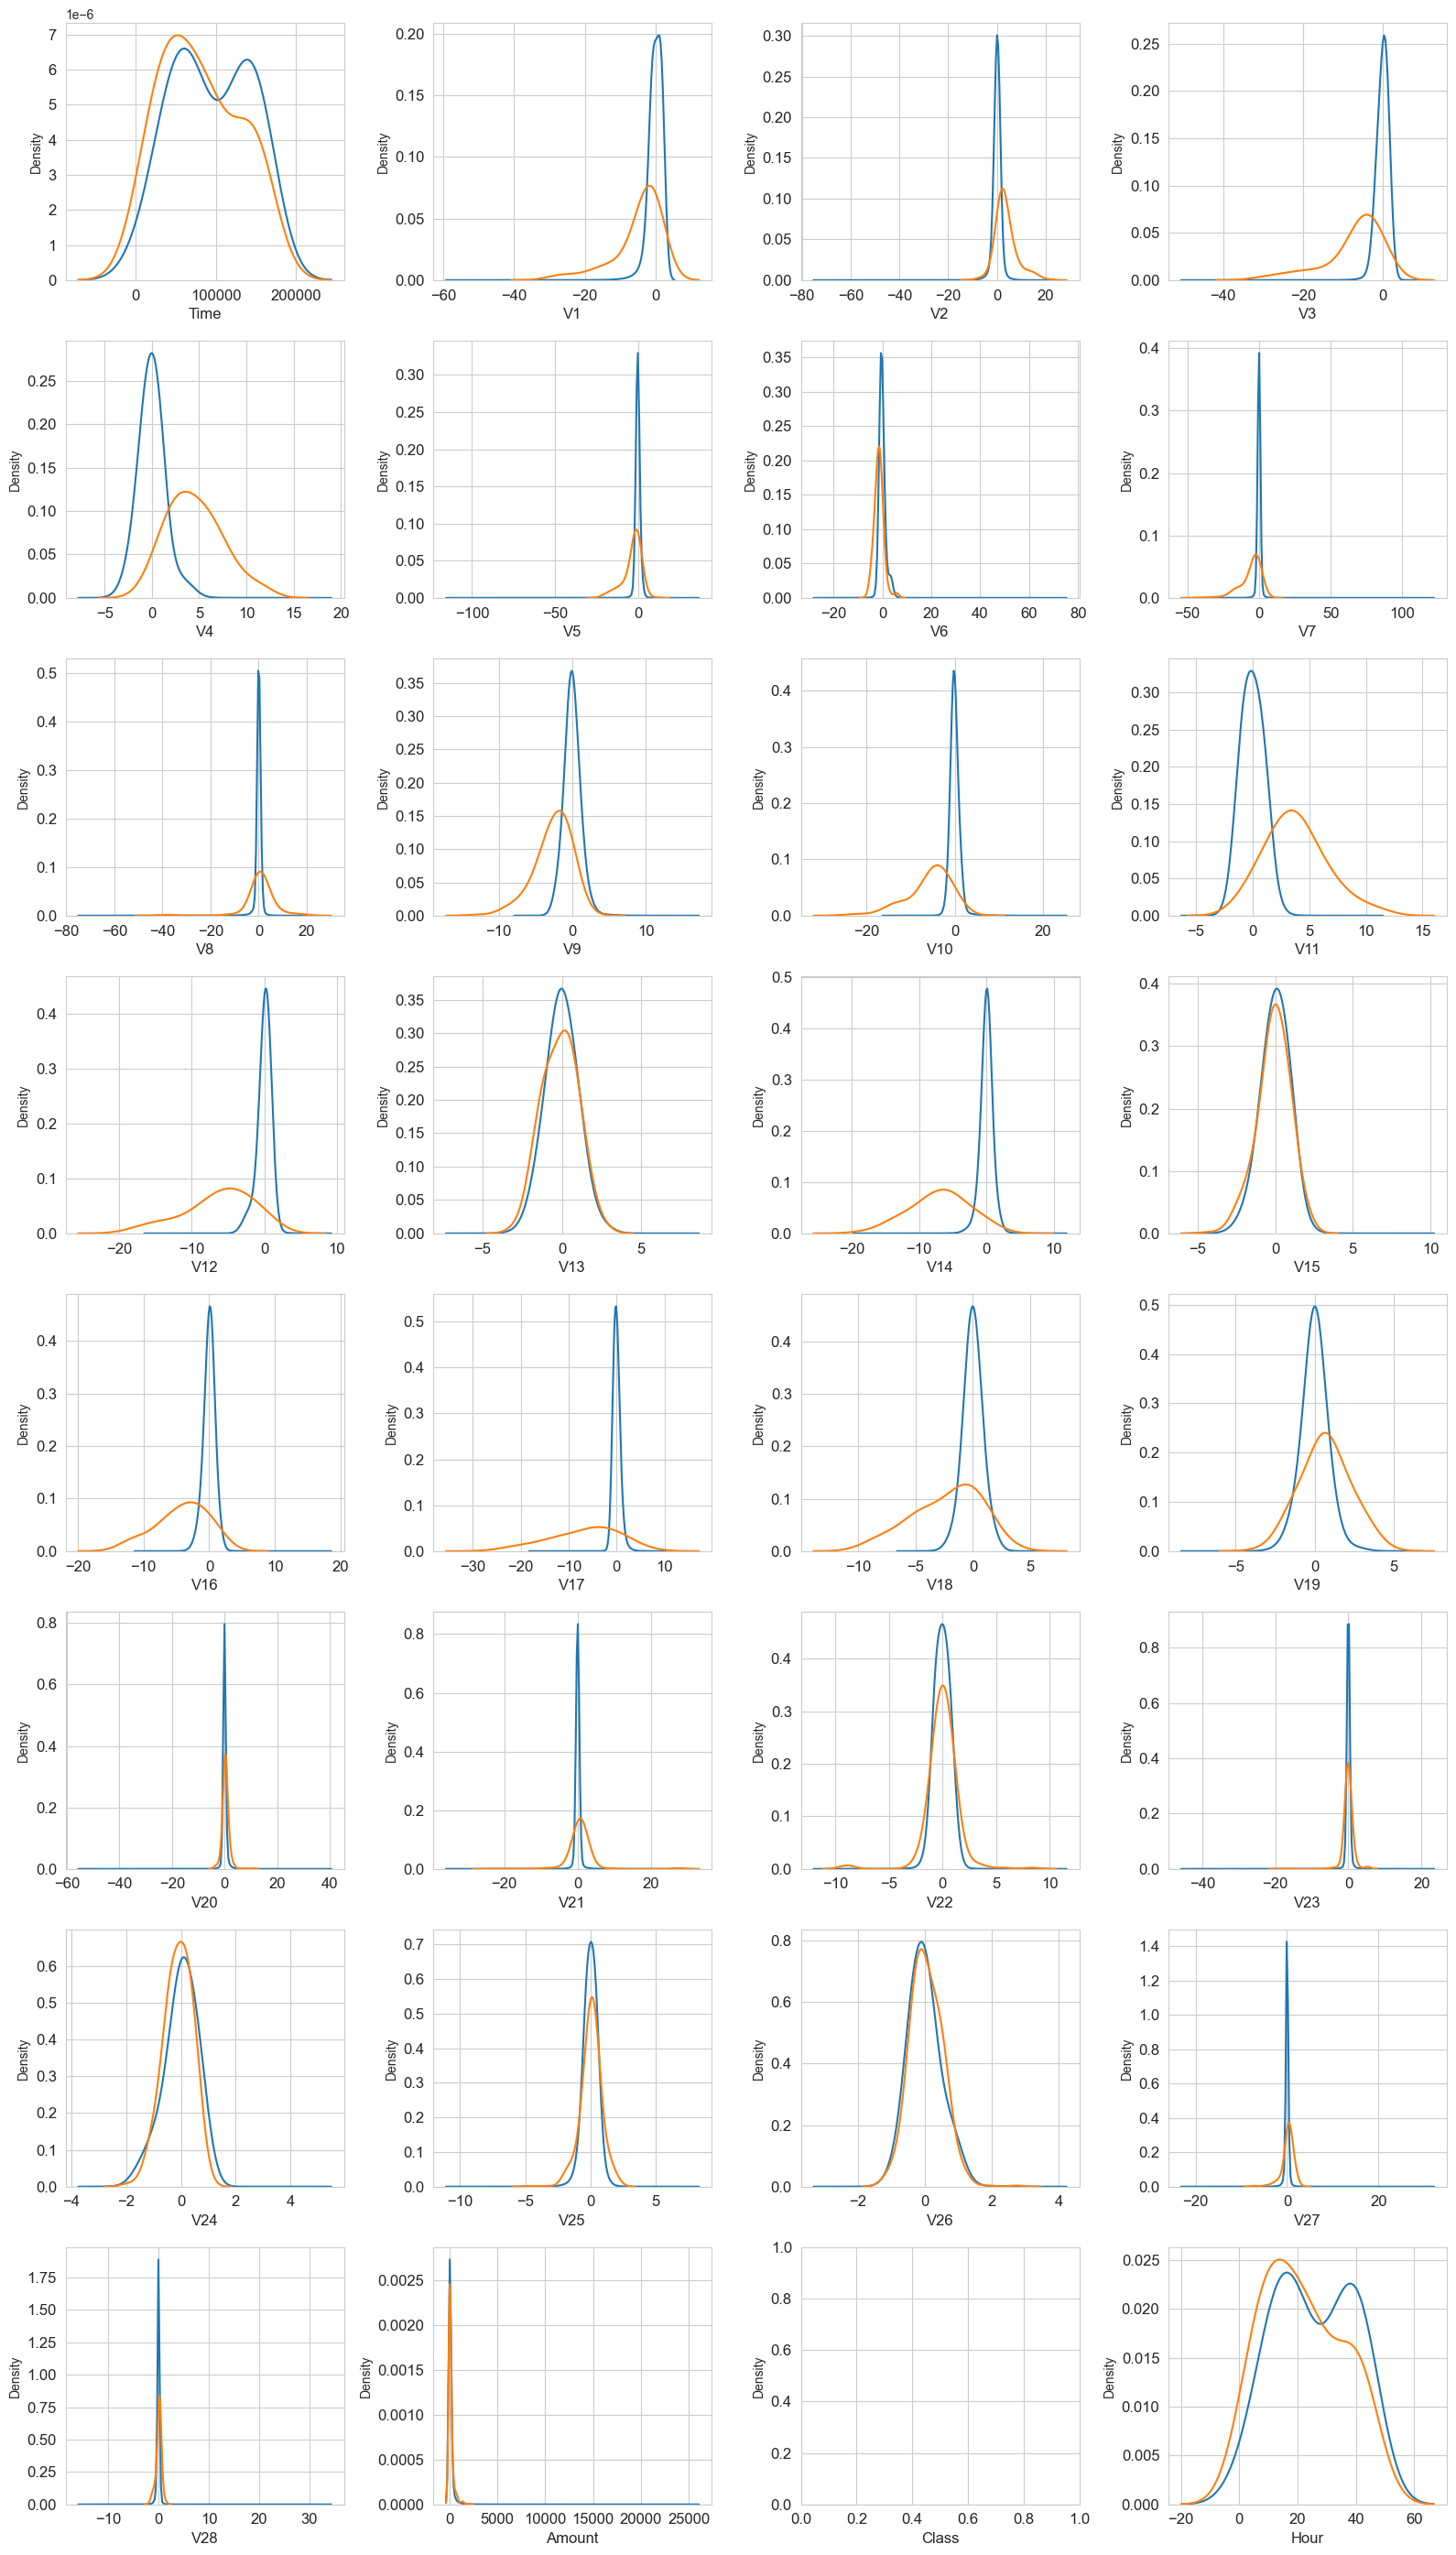

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming data_df is defined with columns and 'Class' as a column
# var = data_df.columns.values
i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
fig, axs = plt.subplots(8, 4, figsize=(16, 28), facecolor='none')  # Set the facecolor of the entire figure

for feature in var:
    i += 1
    ax = plt.subplot(8, 4, i)
    sns.kdeplot(t0[feature], bw=0.5, label="Class = 0", ax=ax)
    sns.kdeplot(t1[feature], bw=0.5, label="Class = 1", ax=ax)
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
    ax.set_facecolor('white')  # Set the background color of each subplot

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('fraud-graphs/kdeplot.png', transparent=True, bbox_inches='tight')  # Save with transparent background
plt.show()


In [82]:
params = {
          'boosting_type': 'gbdt',
          'objective': 'binary',
          'metric':'auc',
          'learning_rate': 0.05,
          'num_leaves': 7,  # we should let it be smaller than 2^(max_depth)
          'max_depth': 4,  # -1 means no limit
          'min_child_samples': 100,  # Minimum number of data need in a child(min_data_in_leaf)
          'max_bin': 100,  # Number of bucketed bin for feature values
          'subsample': 0.9,  # Subsample ratio of the training instance.
          'subsample_freq': 1,  # frequence of subsample, <=0 means no enable
          'colsample_bytree': 0.7,  # Subsample ratio of columns when constructing each tree.
          'min_child_weight': 0,  # Minimum sum of instance weight(hessian) needed in a child(leaf)
          'min_split_gain': 0,  # lambda_l1, lambda_l2 and min_gain_to_split to regularization
          'nthread': 8,
          'verbose': 0,
          'scale_pos_weight':150, # because training data is extremely unbalanced 
         }

In [83]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

In [84]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [85]:
# Prepare the train and valid datasets
dtrain = xgb.DMatrix(train_df[predictors], train_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

#What to monitor (in this case, **train** and **valid**)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Set xgboost parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.039
params['silent'] = True
params['max_depth'] = 2
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'auc'
params['random_state'] = RANDOM_STATE

In [86]:
model = xgb.train(params, 
                dtrain, 
                MAX_ROUNDS, 
                watchlist, 
                early_stopping_rounds=EARLY_STOP, 
                maximize=True, 
                verbose_eval=VERBOSE_EVAL)

[0]	train-auc:0.94070	valid-auc:0.88630


/Users/paniz/Documents/GitHub/shark-tanked/venv/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning:

Pass `evals` as keyword args.

/Users/paniz/Documents/GitHub/shark-tanked/venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning:

[14:09:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "silent" } are not used.




[50]	train-auc:0.94045	valid-auc:0.89040
[100]	train-auc:0.97428	valid-auc:0.96302
[150]	train-auc:0.98695	valid-auc:0.98056
[200]	train-auc:0.99276	valid-auc:0.98504
[250]	train-auc:0.99514	valid-auc:0.98432
[266]	train-auc:0.99569	valid-auc:0.98382


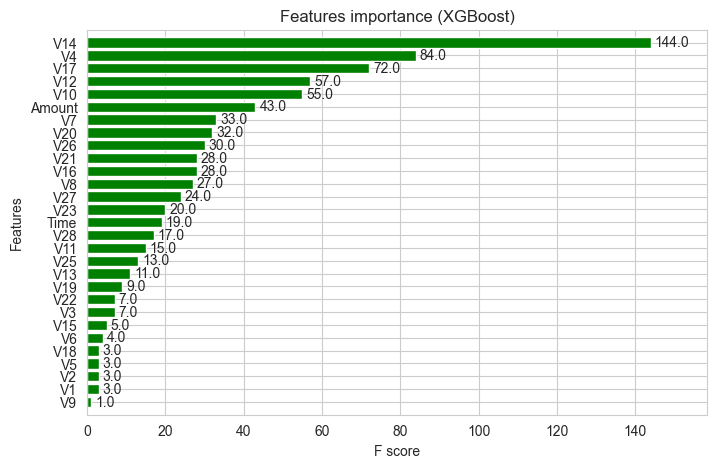

In [88]:
fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(model, height=0.8, title="Features importance (XGBoost)", ax=ax, color="green") 
plt.show()
fig.savefig('fraud-graphs/feature_importance.png', transparent=True, bbox_inches='tight')

In [89]:
preds = model.predict(dtest)

In [90]:
roc_auc_score(test_df[target].values, preds)

0.9806594034680455

In [94]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score  # You can change this depending on your problem

# Assuming that 'train_df' and 'test_df' are your DataFrame and 'target' and 'predictors' are defined
NUMBER_KFOLDS = 5  # Number of K-Folds
RANDOM_STATE = 42  # Random state for reproducibility

folds = KFold(n_splits=NUMBER_KFOLDS, shuffle=True, random_state=RANDOM_STATE)
oof_preds = np.zeros(train_df.shape[0])  # Out-of-fold predictions
test_preds = np.zeros(test_df.shape[0])  # Averaged predictions on the test set
feature_importance_df = pd.DataFrame()

# Define your XGBoost parameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',  # Change according to your problem type
    'eval_metric': 'auc'  # Change metric if needed
}

n_fold = 0
for train_idx, valid_idx in folds.split(train_df[predictors]):
    train_x, train_y = train_df[predictors].iloc[train_idx], train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx], train_df[target].iloc[valid_idx]

    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)
    dtest = xgb.DMatrix(test_df[predictors])  # Assuming 'predictors' are consistent

    eval_results = {}
    model = xgb.train(params, 
                      dtrain, 
                      num_boost_round=1000,  # Number of boosting rounds
                      evals=[(dtrain, 'train'), (dvalid, 'valid')],
                      early_stopping_rounds=50,  # Stop if no improvement
                      evals_result=eval_results,
                      verbose_eval=50)

    # Capture the feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = model.get_score(importance_type='weight').values()
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # Out-of-fold predictions
    # Average test set predictions
    test_preds += model.predict(dtest, iteration_range=(0, model.best_iteration)) / folds.n_splits
    n_fold += 1

# You can add here any post-processing on oof_preds and test_preds like thresholding
print("CV Score:", accuracy_score(train_df[target], np.round(oof_preds)))  # Example CV metric

# Save test predictions if needed
# pd.DataFrame(test_preds).to_csv('test_predictions.csv', index=False)


[0]	train-auc:0.93625	valid-auc:0.95840
[50]	train-auc:0.98489	valid-auc:0.97495
[100]	train-auc:0.99911	valid-auc:0.97753
[116]	train-auc:0.99952	valid-auc:0.97499
[0]	train-auc:0.93712	valid-auc:0.95653
[50]	train-auc:0.98536	valid-auc:0.97487
[100]	train-auc:0.99962	valid-auc:0.98029
[150]	train-auc:0.99996	valid-auc:0.98736
[200]	train-auc:1.00000	valid-auc:0.98698
[231]	train-auc:1.00000	valid-auc:0.98579
[0]	train-auc:0.94064	valid-auc:0.94215
[50]	train-auc:0.98278	valid-auc:0.98218
[100]	train-auc:0.99952	valid-auc:0.98375
[141]	train-auc:0.99994	valid-auc:0.98087
[0]	train-auc:0.94944	valid-auc:0.91501
[50]	train-auc:0.98383	valid-auc:0.97043
[100]	train-auc:0.99965	valid-auc:0.98905
[120]	train-auc:0.99990	valid-auc:0.98804
[0]	train-auc:0.94183	valid-auc:0.93540
[50]	train-auc:0.98597	valid-auc:0.96151
[100]	train-auc:0.99935	valid-auc:0.96920
[150]	train-auc:0.99988	valid-auc:0.97013
[169]	train-auc:0.99995	valid-auc:0.97075
CV Score: 0.9984090061225833


In [101]:
pred = test_preds

In [104]:
print("Test Set predictions:", pred)
#classifying to fraud or not fraud
pred = np.where(pred > 0.5, 1, 0)
print("Test Set predictions after classification:", pred)
#number of fraud transactions
print("Number of fraud transactions:", np.sum(pred))
#number of non-fraud transactions
print("Number of non-fraud transactions:", len(pred) - np.sum(pred))

Test Set predictions: [0 0 0 ... 0 0 0]
Test Set predictions after classification: [0 0 0 ... 0 0 0]
Number of fraud transactions: 82
Number of non-fraud transactions: 56880


In [107]:
model.save_model('fraud_models/xgb_model.json')

XGBoostError: [14:24:14] /Users/runner/work/xgboost/xgboost/dmlc-core/src/io/local_filesys.cc:209: Check failed: allow_null:  LocalFileSystem::Open "fraud_models/xgb_model.json": No such file or directory
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000282b10994 dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000282e16e4c dmlc::io::LocalFileSystem::Open(dmlc::io::URI const&, char const*, bool) + 808
  [bt] (2) 3   libxgboost.dylib                    0x0000000282e09678 dmlc::Stream::Create(char const*, char const*, bool) + 68
  [bt] (3) 4   libxgboost.dylib                    0x0000000282b362e8 XGBoosterSaveModel + 116
  [bt] (4) 5   libffi.8.dylib                      0x0000000104da004c ffi_call_SYSV + 76
  [bt] (5) 6   libffi.8.dylib                      0x0000000104d9d834 ffi_call_int + 1404
  [bt] (6) 7   _ctypes.cpython-311-darwin.so       0x0000000105990150 _ctypes_callproc + 752
  [bt] (7) 8   _ctypes.cpython-311-darwin.so       0x000000010598a4b4 PyCFuncPtr_call + 228
  [bt] (8) 9   python3.11                          0x0000000102bd5034 _PyEval_EvalFrameDefault + 197300

